In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import anndata as ad

In [24]:
#load in data
he48 = ad.read_h5ad('/Users/jordankalai/Documents/Stanford/bio265/bio265_project/he48_processed.h5ad')
# Calculate the neighbors of each cell, which is part of the UMAP method
sc.pp.neighbors(he48, n_neighbors=15, n_pcs=50, method="umap")
# Cluster the cells
# The leiden algorithm is the standard in the field, and performs better than regular k-means for single cell data
# I arbitrarily chose a resolution, which in this case gave us 16 clusters (instead of choosing a cluster number ahead of time)
# This is a pretty reasonable number for the number of celltypes you would see at this stage
sc.tl.leiden(he48, resolution=1.2, flavor="leidenalg", key_added="leiden")

In [25]:
# Perform the final UMAP analysis step
sc.tl.umap(he48)

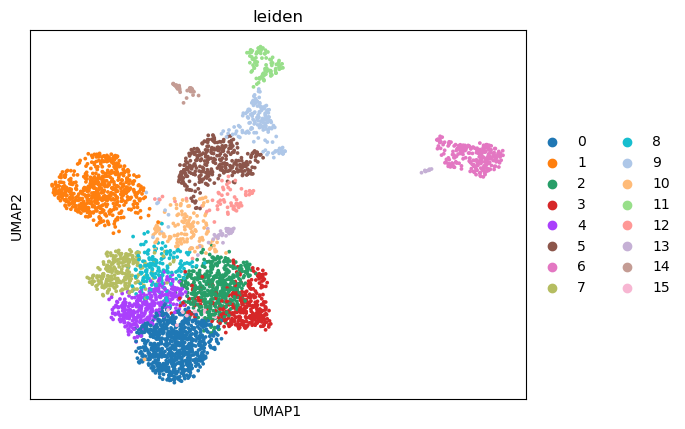

In [26]:
# Plot the first two UMAP dimensions
# Color cells by the cluster they belong to
sc.pl.umap(he48, color=["leiden"])

In [30]:
# Calculate the marker genes for each cell cluster
# Use the wilcoxon test, which performs well for single cell data
# Provide adjusted p-values using the benjamini-hochberg correction
sc.tl.rank_genes_groups(he48, "leiden", method="wilcoxon", corr_method='benjamini-hochberg')

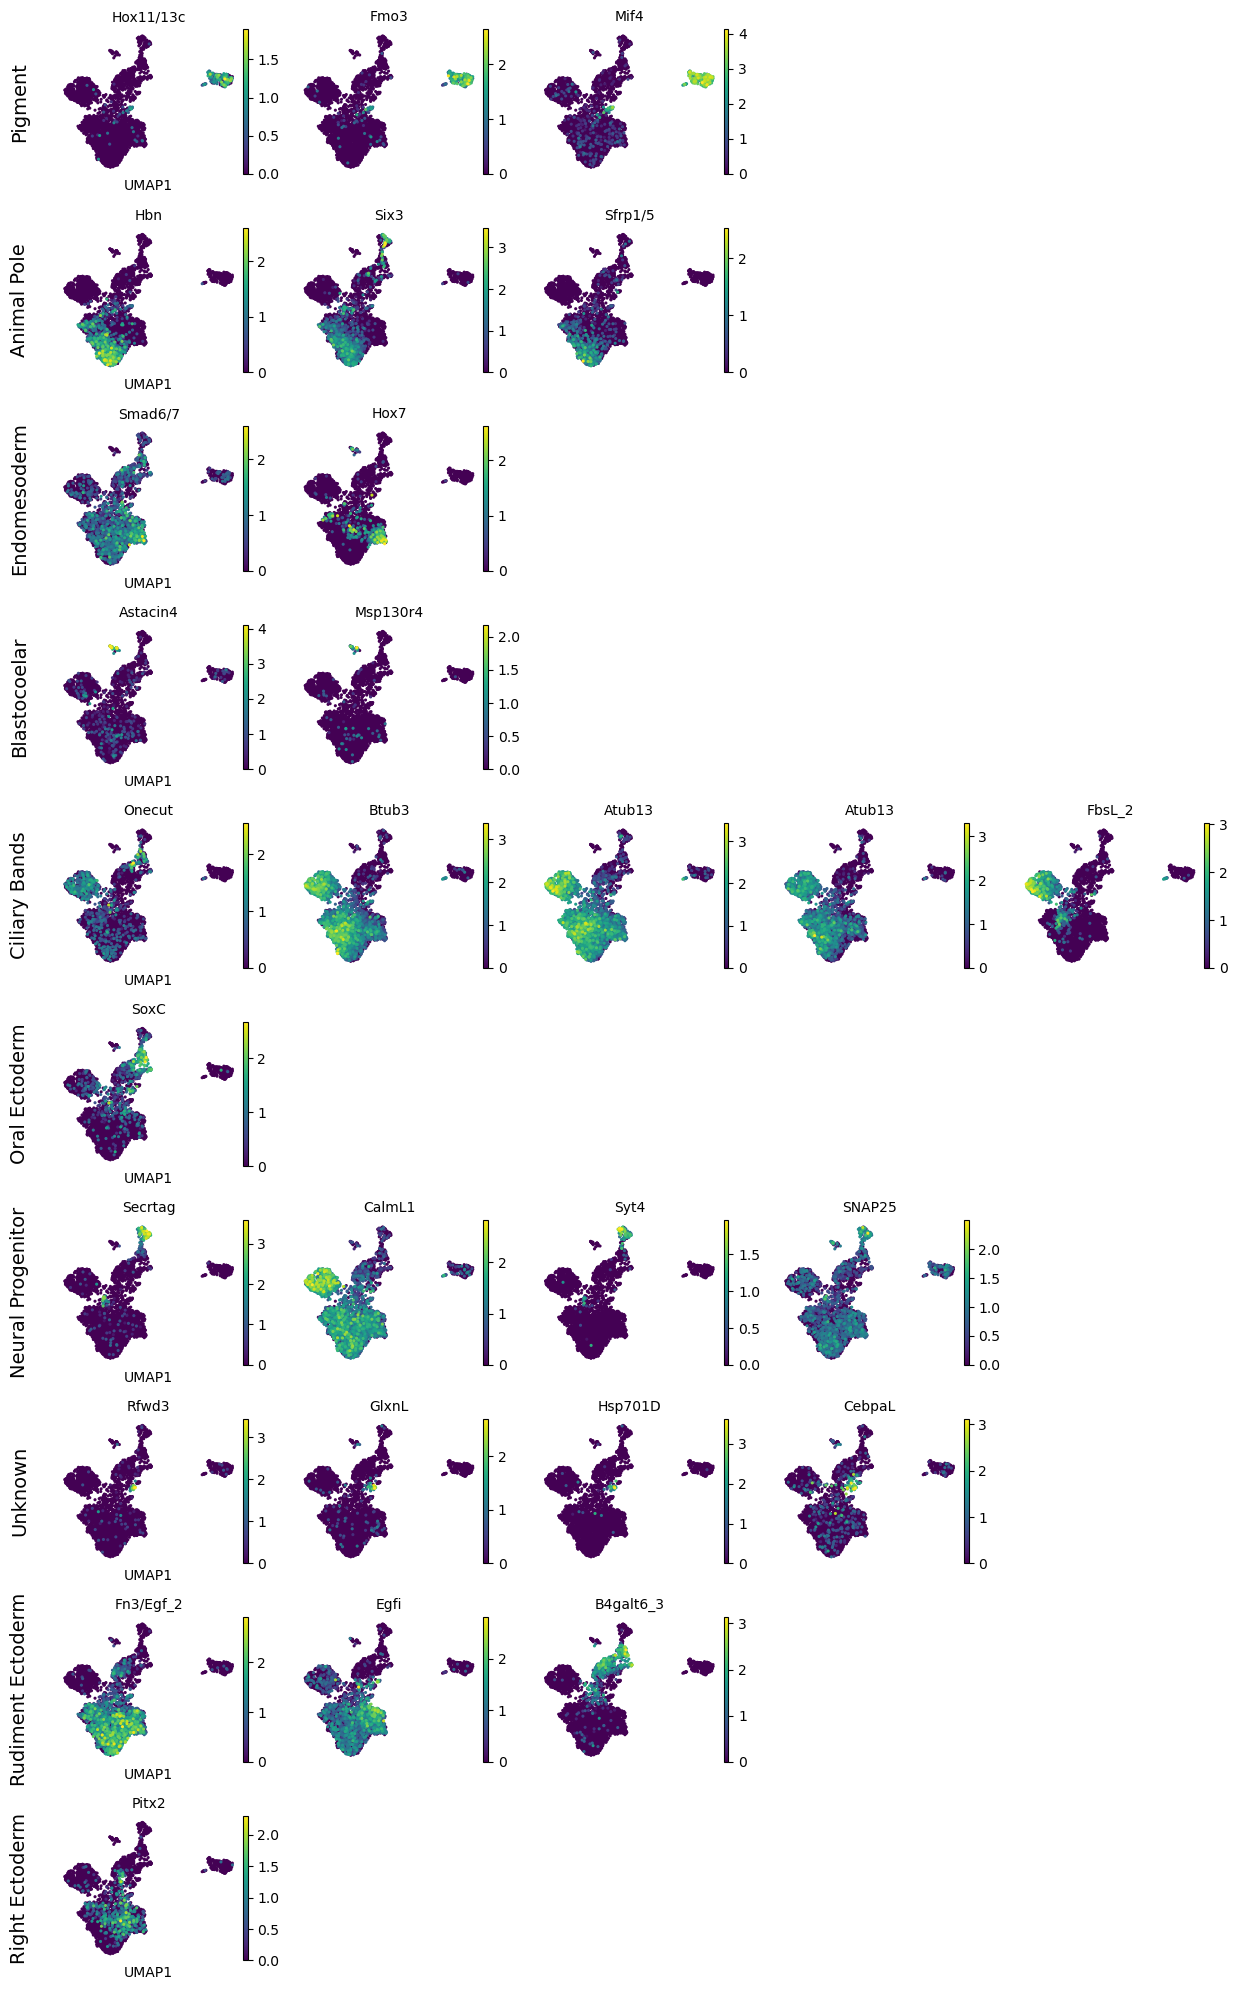

In [31]:
# In this example we want to show UMAPs of different cell type markers,
# with markers of a single cell type in one row
# and with a different number of markers per cell type (row)

# Marker genes
marker_genes = {
    "Pigment": ["HER_21404.t1:Sp-Hox11/13c", "HER_47443.t1:Sp-Fmo3", "HER_46925.t1:Sp-Mif4"],
    "Animal Pole": ["HER_10974.t1:Sp-Hbn", "HER_17866.t1:Sp-Six3", "HER_33519.t1:Sp-Sfrp1/5"],
    "Endomesoderm": ["HER_39372.t1:Sp-Smad6/7", "HER_40059.t1:Sp-Hox7"],
    "Blastocoelar": ["HER_45847.t1:Sp-Astacin4", "HER_28292.t1:Sp-Msp130r4"],
    "Ciliary Bands": ["HER_33009.t1:Sp-Onecut", "HER_45861.t1:Sp-Btub3", "HER_35876.t1:Sp-Atub13", "HER_35862.t1:Sp-Atub13", "HER_28.t1:Sp-FbsL_2"],
    "Oral Ectoderm": ["HER_3624.t1:Sp-SoxC"],
    #"Aboral Ectoderm": ["HER_49824.t1:Sp-Ars"],
    #"Posterior Ectoderm": ["HER_40059.t1:Sp-Hox7", "HER_10395.t1_HER_10396.t1:Sp-WntA", "HER_48747.t1:Sp-Lox"],
    "Neural Progenitor": ["HER_45795.t1:Sp-Secrtag", "HER_19128.t2:Sp-CalmL1", "HER_10174.t1:Sp-Syt4", "HER_18945.t1:Sp-SNAP25"],
    "Unknown": ["HER_33417.t1:Sp-Rfwd3", "HER_17148.t1:Sp-GlxnL", "HER_47859.t1:Sp-Hsp701D", "HER_45097.t1:Sp-CebpaL",],
    "Rudiment Ectoderm": ["HER_20019.t1:Sp-Fn3/Egf_2", "HER_20850.t1:Sp-Egfi", "HER_13245.t1_HER_13243.t1:Sp-B4galt6_3"],
    "Right Ectoderm": ["HER_23589.t1:Sp-Pitx2"],
    #"Ribosomal":["HER_49716.t1:Sp-Rpl21", "HER_728.t1:Sp-Rpl6", "HER_22572.t1:Sp-Rpl11", "HER_11034.t1:Sp-Rps17", "HER_30087.t1:Sp-Rpl37a", "HER_25966.t1:Sp-Rpl36a"]
}
# Make Axes
# Number of needed rows and columns (based on the row with the most columns)
nrow = len(marker_genes)
ncol = max([len(vs) for vs in marker_genes.values()])
fig, axs = plt.subplots(nrow, ncol, figsize=(2.5 * ncol, 2 * nrow))
# Plot expression for every marker on the corresponding Axes object
for row_idx, (cell_type, markers) in enumerate(marker_genes.items()):
    col_idx = 0
    for marker in markers:
        ax = axs[row_idx, col_idx]
        sc.pl.umap(he48, color=marker, ax=ax, show=False, frameon=False, s=20)

        # Extract the part after "-" for the title
        marker_name = marker.split(":")[-1]  # Extracts 'Sp-*' part
        marker_name = marker_name.split("-")[-1]  # Extracts the final part after "-"

        ax.set_title(marker_name, fontsize=10)  # Set the title
        # Add cell type as row label - here we simply add it as ylabel of
        # the first Axes object in the row
        if col_idx == 0:
            # We disabled axis drawing in UMAP to have plots without background and border
            # so we need to re-enable axis to plot the ylabel
            ax.axis("on")
            ax.tick_params(
                top="off",
                bottom="off",
                left="off",
                right="off",
                labelleft="on",
                labelbottom="off",
            )
            ax.set_ylabel(cell_type + "\n", rotation=90, fontsize=14)
            ax.set(frame_on=False)
        col_idx += 1
    # Remove unused column Axes in the current row
    while col_idx < ncol:
        axs[row_idx, col_idx].remove()
        col_idx += 1
# Alignment within the Figure
fig.tight_layout()
plt.savefig('/Users/jordankalai/Documents/Stanford/bio265/umap_logfoldbygene.png')

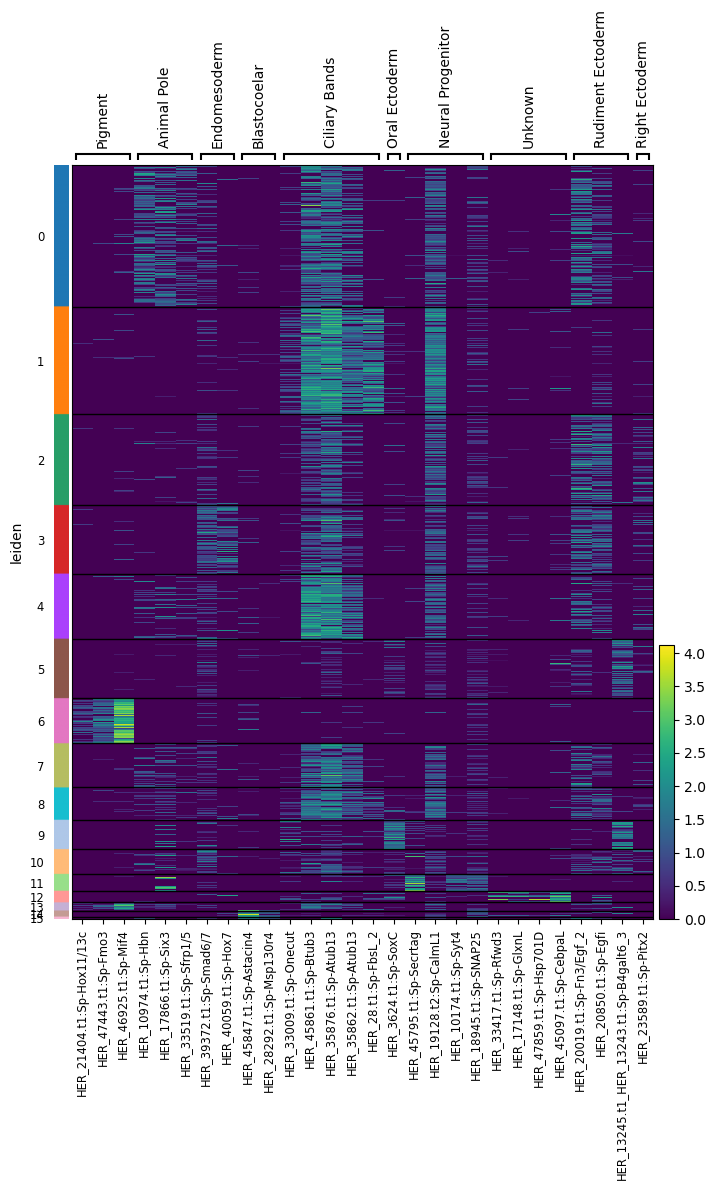

In [34]:
ax = sc.pl.heatmap(
    he48, marker_genes, groupby="leiden", cmap="viridis", dendrogram=False, figsize=(8,10), save='heatmap_logfoldbygene.png'
)
#plt.savefig('/Users/jordankalai/Documents/Stanford/bio265/heatmap_logfoldbygene.png')

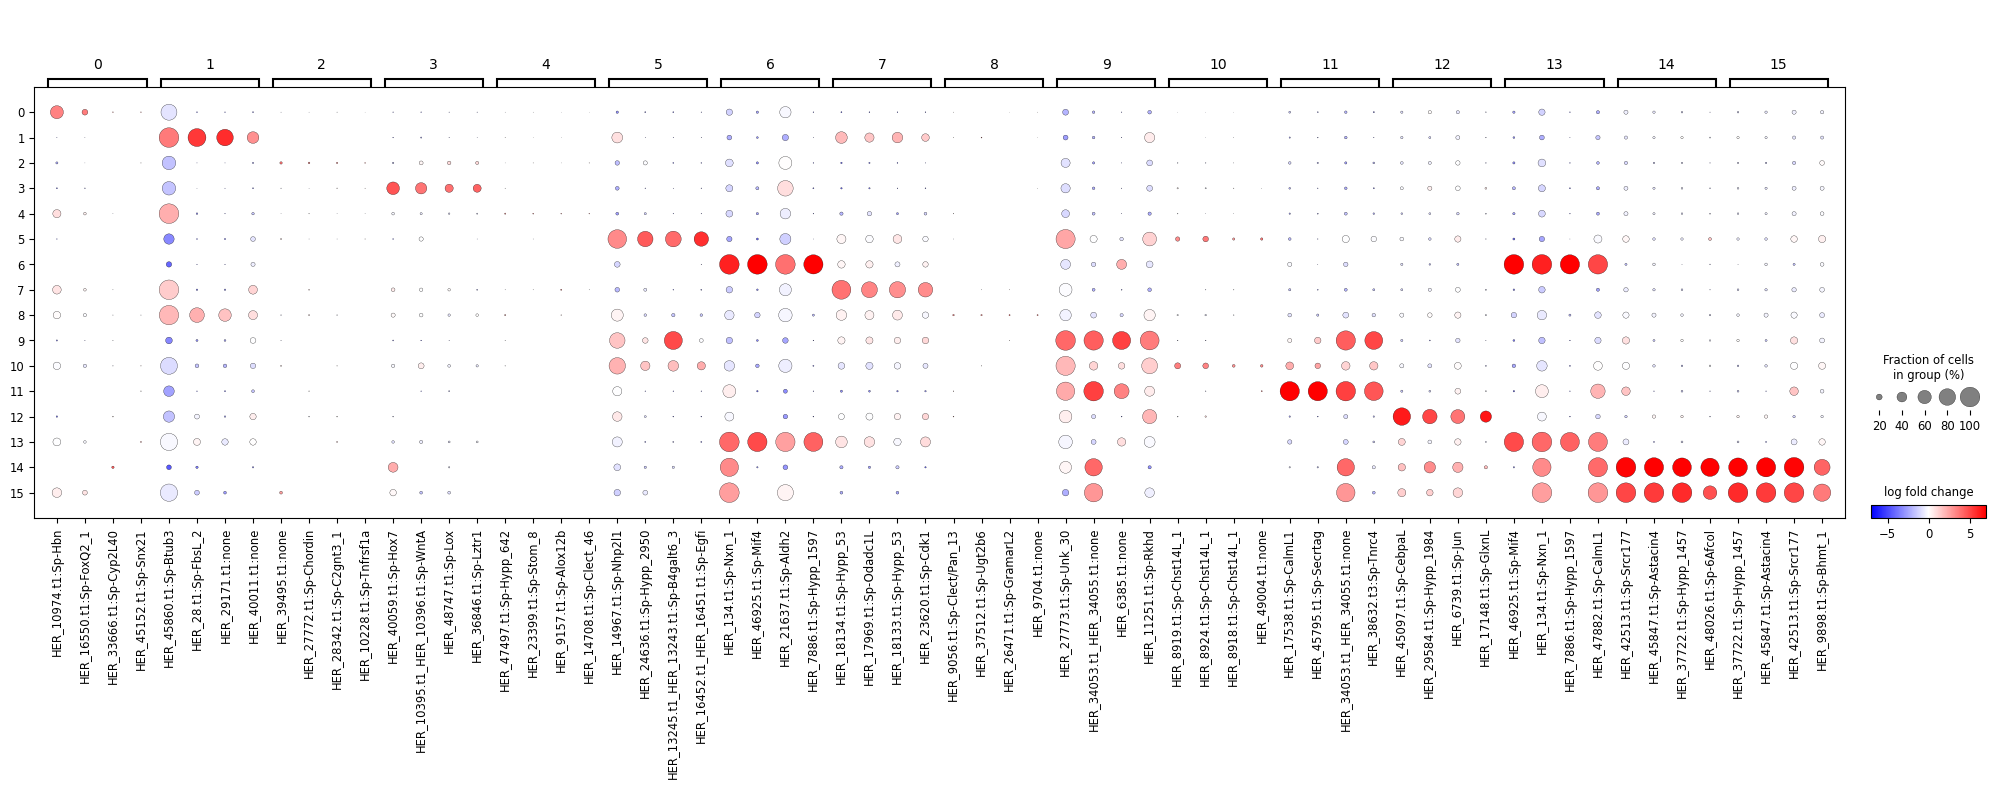

In [19]:
sc.pl.rank_genes_groups_dotplot(
    he48,
    n_genes=4,
    values_to_plot="logfoldchanges",
    min_logfoldchange=3,
    vmax=7,
    vmin=-7,
    cmap="bwr",
    dendrogram=False
)

Axes: Axes(0.146628,0.15;0.568915x0.73)


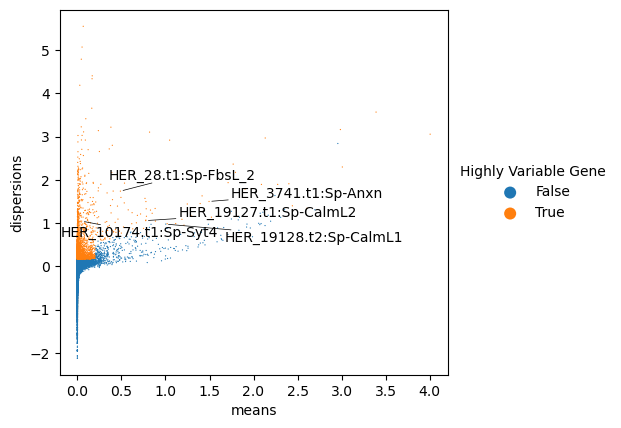

In [54]:
#create labeled highly variable plot with some interesting genes
# Package used for adding well aligned labels on the plot
#!pip install adjustText
from adjustText import adjust_text

with plt.rc_context({"figure.figsize": (5, 5)}):
    x = "means"
    y = "dispersions"
    color = "is_highly_variable"
    he48.var["is_highly_variable"] = (
        he48.var["highly_variable"].astype(bool).astype(str)
    )
    ax = sc.pl.scatter(he48, x=x, y=y, color=color, show=False)
    print("Axes:", ax)
    # Move plot title from Axes to Legend
    ax.set_title("")
    ax.get_legend().set_title("Highly Variable Gene")

    # Labels

    # Select genes to be labeled
    texts = []
    #highlighting proteins relating to calcium right now --> could be good to maybe highlight ones that relate to the cytoskeleton: gsn, 
    genes = [
        "HER_19128.t2:Sp-CalmL1",
        "HER_19127.t1:Sp-CalmL2",
        "HER_3741.t1:Sp-Anxn", #calcium-dependent phospholipid-binding proteins
        "HER_28.t1:Sp-FbsL_2",
        "HER_10174.t1:Sp-Syt4",
    ]
    for gene in genes:
        # Position of object to be marked
        #gene = gene.split(":")[-1]  # take out 'Sp-*' part
        #gene = gene.split("-")[-1]  # take out the final part after "-"
        x_loc = he48.var.at[gene, x]
        y_loc = he48.var.at[gene, y]
        # Text color
        color_point = "k"
        # take the part after "-" for the title
        #print(gene)
        texts.append(ax.text(x_loc, y_loc, gene, color=color_point, fontsize=10))

    # Label selected genes on the plot
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
plt.show()